#### Reference by : https://github.com/herbwood/pytorch_faster_r_cnn/blob/main/faster_r_cnn.ipynb

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import json 

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(DEVICE, torch.cuda.get_device_name(0))
    
else:
    DEVICE = torchc.device("cpu")
    print(DEVICE)

cuda Quadro RTX 6000


# Data Preprocessing

## 1) Visualize Image and bounding boxes

### 1. Data load & Visualization

(4032, 3024, 3)


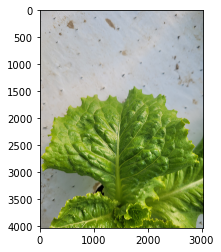

In [5]:
img0 = cv2.imread("/home/ubuntu/lecttue-diagonosis/data/vegetable_data/Training/normal_lecttue/V006_77_0_00_05_03_12_0_c29_20201126_1342_S01_1.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

#### 2. Load Bounding boxes data

In [6]:
with open('/home/ubuntu/lecttue-diagonosis/data/vegetable_data/Training/normal_lecttue_label/V006_77_0_00_05_03_12_0_c29_20201126_1342_S01_1.jpg.json','r')as file:
    data = json.load(file)
    
bbox0 = np.array([data["annotations"]["points"][0]['xtl'],
                data["annotations"]["points"][0]['ytl'],
                data["annotations"]["points"][0]['xbr'],
                data["annotations"]["points"][0]['ybr'],])
labels = np.array(data["annotations"]["disease"])

#### 3. Display bounding boox and labels

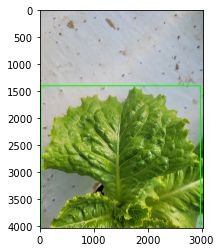

In [7]:
img0_clone = np.copy(img0)

cv2.rectangle(img0_clone, (bbox0), color = (0,255,0), thickness = 20)
    
plt.imshow(img0_clone)
plt.show()

## 2) Resize Image and bounding boxes

### 1. Change Image size

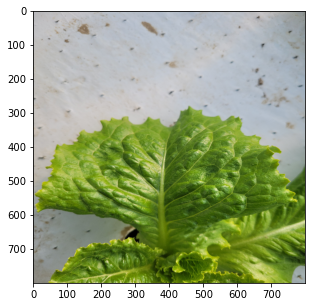

In [8]:
img = cv2.resize(img0, dsize = (800,800), interpolation = cv2.INTER_CUBIC)
plt.figure(figsize = (5,5))
plt.imshow(img)

### 2. Change BBOX Size

0.26455026455026454 0.1984126984126984


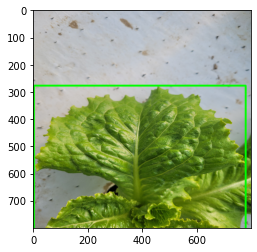

In [42]:
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]

print(Wratio, Hratio)

ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

box = np.array([int(a*b) for a,b in zip(bbox0, ratioList)]) #different point because of our image is onle one object)

img_clone = np.copy(img)

cv2.rectangle(img_clone, (box[0], box[1], box[2], box[3]), color = (0, 255, 0), thickness = 5)

plt.imshow(img_clone)
plt.show()

# Define Feature Extractor

# 1) Load Pretrained VGC16

In [47]:
model = torchvision.models.vgg16(pretrained = True).to(DEVICE)
features = list(model.features)
print(len(features))
print(features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

## 2) Only Collect required layers

### 1. only collect layers with output feature map size (W,H) < 50

In [58]:
dummy_img = torch.zeros((1,3,800,800)).float()
print(dummy_img.shape)

req_features = []
output = dummy_img.clone().to(DEVICE)

for feature in features:
    output = feature(output)
    # print(output.size() => torch.Size([batch_size, channel, width, height]))
    
    if output.size()[2] < 800//16:
        break
    req_features.append(feature)
    out_channels = output.size()[1]
    
print(len(req_features))
print(out_channels)

torch.Size([1, 3, 800, 800])
30
512


### 2. Convert this list into a seqeuntial Module

In [60]:
faster_rcnn_feature_extractor = nn.Sequential(*req_features)

### 3. test the result of the input image pass through the feature extractor

In [62]:
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(DEVICE)
imgTensor = imgTensor.unsqueeze(0)
output_map = faster_rcnn_feature_extractor(imgTensor)

print(output_map.size())

torch.Size([1, 512, 50, 50])


### 4. Visualiza the first 5 channels of the 50 * 50 * 512 feature maps

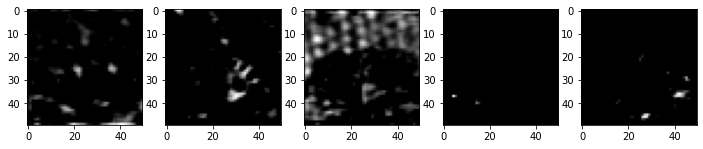

In [63]:
imgArray = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize = (12,4))
figNo = 1

for i in range (5):
    fig.add_subplot(1,5, figNo)
    plt.imshow(imgArray[i], cmap = 'gray')
    figNo += 1
    
plt.show()

# Generate Anchors Boxes

## 1) Generate Anchors

* sub-sampling rate = 1/16
* image size : 800 x 800
* sub-sampled feature map size : 800 x 1/16 = 50
* 50 x 50 = 2500 anchors and each anchor generate 9 anchor boxes
* total anchor boxes = 50 x 50 x 9 = 22500
* x,y intervals to generate anchor box center

In [65]:
feature_size = 800 // 16
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)

print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


### 1. coordinates of the 255 center points to generate anchor boxes

In [66]:
index = 0
ctr = np.zeros((2500, 2))

for i in range (len(ctr_x)):
    for j in range (len(ctr_y)):
        ctr[index, 1 ] = ctr_x[i] - 8
        ctr[index, 0 ] = ctr_y[j] - 8
        index += 1
        
print(ctr.shape)
print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 [ 56.   8.]
 [ 72.   8.]
 [ 88.   8.]
 [104.   8.]
 [120.   8.]
 [136.   8.]
 [152.   8.]]


### 2. display the 2500 anchors within image

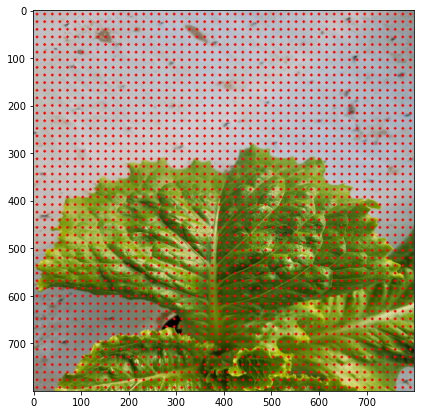

In [75]:
img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize = (7,7))

for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=3)
    
plt.imshow(img_clone2)
plt.show()

## 2) Generate Anchor boxes

* for each of the 2500 anchors, generate 9 anchor boxes
* 2500 X 9 = 22500 anchor boxes

In [76]:
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9 ), 4))
index = 0

for c in ctr: #per anchors
    ctr_y, ctr_x = c
    for i in range (len(ratios)):  # per ratios
        for j in range (len(scales)):  #per scales
            
            #anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ratios[i])
            
            #anchor box[x1,y1,x2,y2]
            anchor_boxes[index,1] = ctr_y - h /2.
            anchor_boxes[index,0] = ctr_x - w /2.
            anchor_boxes[index,3] = ctr_y + h /2.
            anchor_boxes[index,2] = ctr_y + w /2.
            index += 1
            
print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834    114.50966799   69.254834  ]]


### 1. display the anchor boxes of one anchor and the ground truth boxes

#### road Image

In [81]:
img_clone = np.copy(img)

#### Draw Random Anchor Boxes

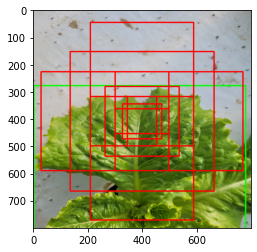

In [85]:
for i in range (11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1,y1), (x2,y2), color = (255, 0, 0),
                  thickness = 3)

plt.imshow(img_clone)
plt.show()

#### draw ground truth boxes

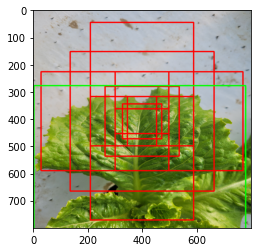

In [86]:
cv2.rectangle(img_clone,box,color = (0,255,0), thickness = 3)
    
plt.imshow(img_clone)
plt.show()
    

#### draw all anchor boxes

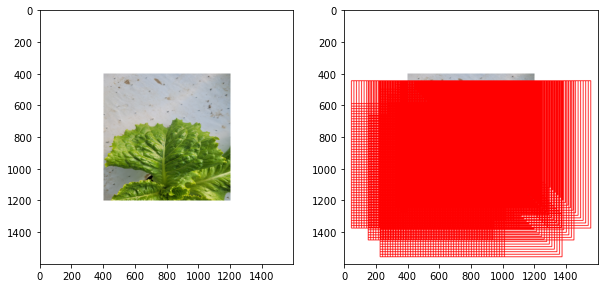

In [92]:
#add paddings(can't draw anchor boxes out of image boundary)

img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3, 400, 400, 400, 400, cv2.BORDER_CONSTANT, value = (255,255,255))
img_clone5 = np.copy(img_clone4)

for i in range (len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    x2 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1 + 400, y1 + 400), (x2 + 400, y2 + 400), color = (255,0,0), thickness = 3)
    
plt.figure(figsize = (10,10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

# Target Anchors

## 1) Only choose anchor boxes inside the image

* ignore the corss boundary anchor boxes
* valid anchor boxes with (x1,y1) > 0 and (x2, y2) <= 800

In [118]:
index_inside = np.where((anchor_boxes[:, 0] >= 0) &
                       (anchor_boxes[:,1] >= 0) &
                       (anchor_boxes[:,2] <= 800) & 
                       (anchor_boxes[:,3] <= 800))[0]

print(index_inside.shape)

(10669,)


### only 8940 anchor boxes are inside the boundary out of 22500

In [120]:
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes)

[[ 10.745166    13.49033201 149.254834   194.50966799]
 [ 10.745166    29.49033201 165.254834   210.50966799]
 [ 10.745166    45.49033201 181.254834   226.50966799]
 ...
 [746.745166   605.49033201 741.254834   786.50966799]
 [728.         648.         776.         776.        ]
 [728.         664.         792.         792.        ]]
